In [1]:
from manifold_flow.flows import ManifoldFlow
from manifold_flow import transforms
from manifold_flow.architectures.vector_transforms import create_vector_transform

import numpy as np
import torch
from tqdm import tqdm
from pathlib import Path
from math import sqrt
import matplotlib.pyplot as plt

from two_spirals_utils import spiral_dataset

In [2]:
# Define M-Flow model
mflow = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=transforms.ConditionalAffineScalarTransform(features=1),
    outer_transform=create_vector_transform(dim=2, flow_steps=16)
)

mflow.load_state_dict(torch.load("../models/spirals/spiral_mflow_D.pt"))

<All keys matched successfully>

### Load "Two Spirals" dataset

In [3]:
# Load the "Two Spirals" dataset from disk
loaded_dataset = torch.load("../data/two_spirals/spiral_dataset_20k.pt")

# Extract X from the loaded dataset
X = loaded_dataset["X"]

In [4]:
# Sample many points from the model to visualise the learned manifold
mflow.eval()
manifold_points = mflow.sample(n=10_000).detach().numpy()

In [5]:
def generate_grid_tensor(
        n_points_per_axis: int,
        min_val:           float,
        max_val:           float
    ) -> torch.Tensor:
    linspace    = torch.linspace(min_val, max_val, n_points_per_axis)
    x, y        = torch.meshgrid(linspace, linspace, indexing="ij")
    grid_points = torch.stack([x.flatten(), y.flatten()], dim=-1)
    return grid_points

### Visualise _on-manifold_ projection trajectories in data space

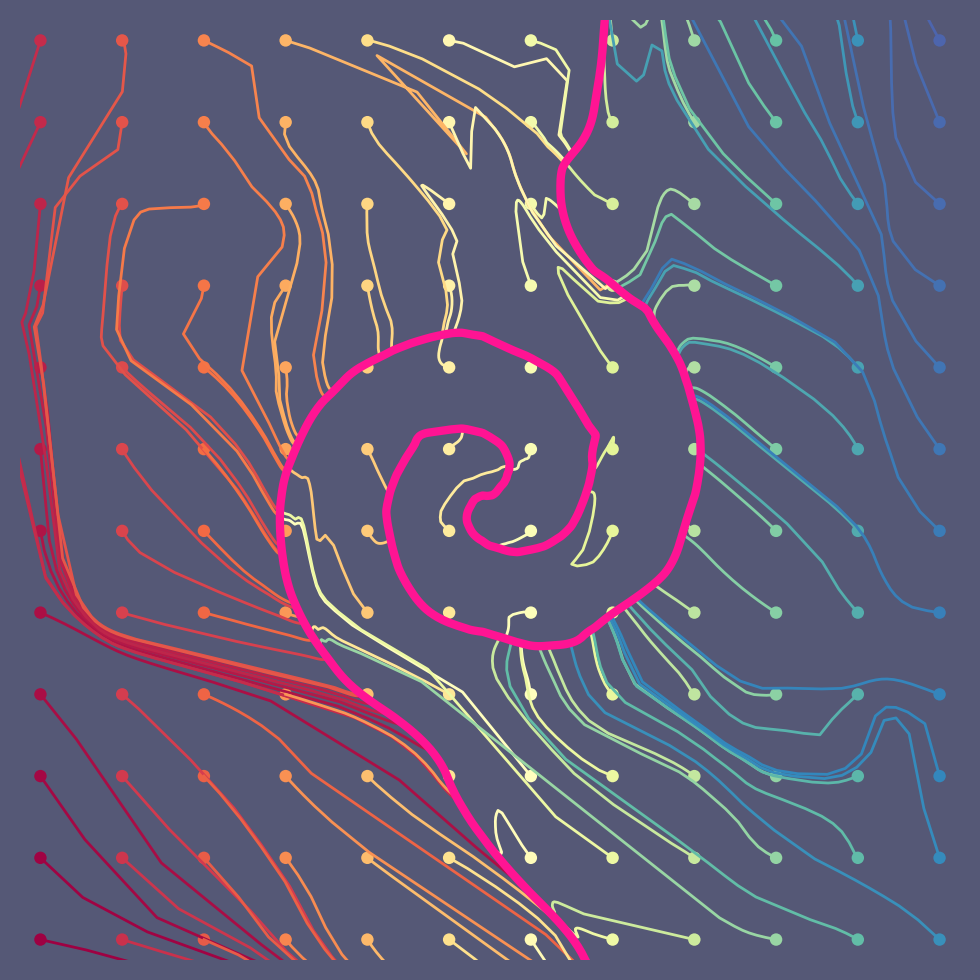

In [6]:
# Generate random colours for the sample points
n_samples     = 150
random_values = torch.rand(n_samples)
# colours       = plt.colormaps["hsv"](random_values)[:, :3]
grid_colours  = plt.colormaps["Spectral"](np.linspace(0, 1, n_samples))[:, :3]

# Generate poins on a regular grid
grid_points   = generate_grid_tensor(int(sqrt(n_samples)), -2.2, 2.2)
n_grid_points = grid_points.shape[0]

n_manifold_samples = 10000
zero_levelset = torch.linspace(-10, 10, n_manifold_samples)
points_manifold = mflow.decode(zero_levelset[:,None]).detach().numpy()

points_lat  = mflow.encode(grid_points)
points_proj = mflow.decode(points_lat).detach().numpy()

# Set colours for grid points with y = 0 to pink
zero_levelset_mask = (grid_points[:, 1].abs() < 0.0000001)
zero_levelset_idxs = torch.nonzero(zero_levelset_mask, as_tuple=True)[0]
# grid_colours[zero_levelset_idxs] = torch.tensor([1, 0, 1])

# Define arrays used for plotting the projection vectors via `plt.quiver` 
x_start, y_start = grid_points.T.numpy()
x_end,   y_end   = points_proj.T
dx               = x_end - x_start
dy               = y_end - y_start

# Plotting
fig = plt.figure(figsize=(5, 5), dpi=200)

# Set background colour
fig.patch.set_facecolor("#555876")

grid_colours = grid_colours[:grid_points.shape[0]]

# PLOT PROJECTION TRAJECTORIES IN DATA SPACE

# Over how many steps do we scale down v to 0?
n_steps = 100

# Map grid points from data space to 2D latent space
points_latent2d = mflow.outer_transform(grid_points)[0]

# Initialise tensor that stores projection trajectories for all grid points
trajectories = torch.zeros((n_steps, grid_points.shape[0], 2))

for idx, interp_lambda in enumerate(torch.linspace(0, 1, n_steps)):
    points_latent2d_scaled = points_latent2d
    points_latent2d_scaled[:, 1] *= (1 - interp_lambda)
    
    trajectories[idx] = mflow.outer_transform.inverse(points_latent2d_scaled)[0].detach()

trajectories = trajectories.permute(1, 0, 2).numpy()

for idx, point_trajectory in enumerate(trajectories):
    plt.plot(*point_trajectory.T, c=grid_colours[idx], lw=1)

plt.plot(*points_manifold.T, alpha=1, c="deeppink",   lw=3)
plt.scatter(*grid_points.T,  alpha=1, c=grid_colours, lw=0, s=20)

plt.gca().set_aspect("equal", adjustable="box")
plt.axis("off")
plt.xlim(-2.3, 2.3)
plt.ylim(-2.3, 2.3)
plt.tight_layout()
# plt.savefig("../figures/report/trajectories_D.pdf")

# Transform a horizontal line from latent space to ambient space

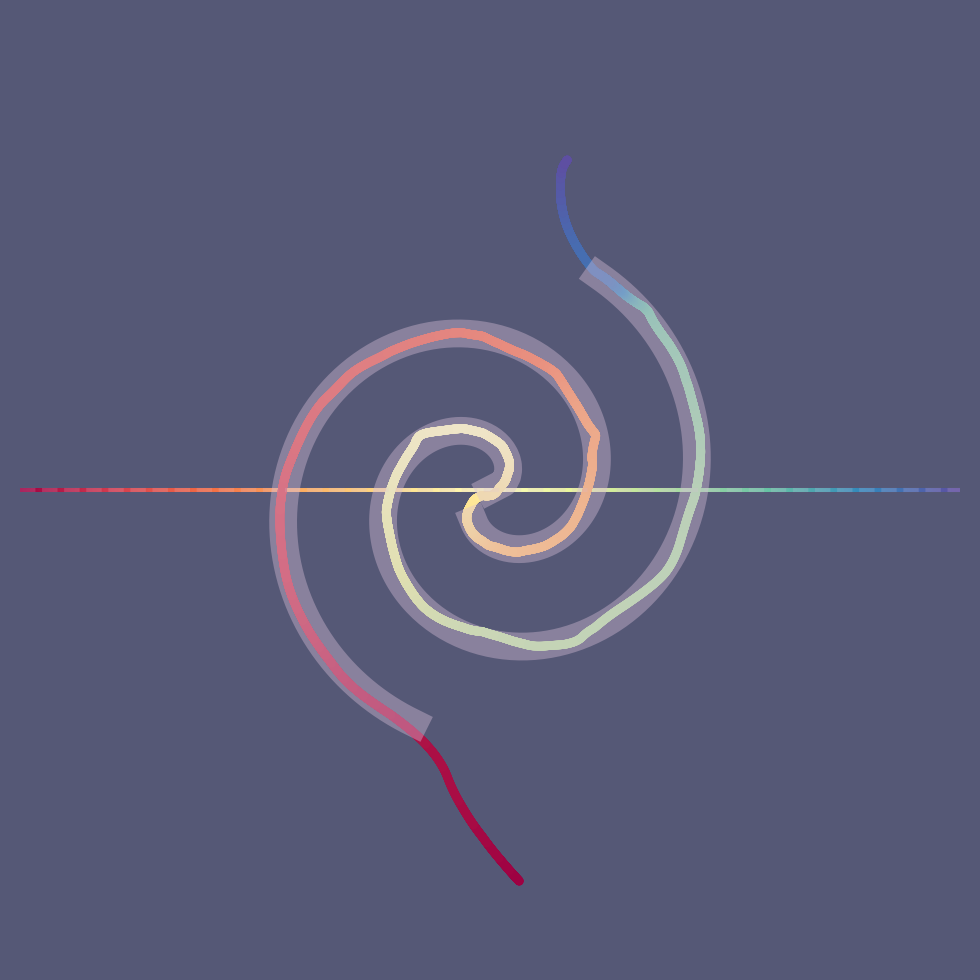

In [9]:
# Generate colours for the sample points
n_samples     = 2**14
grid_points   = generate_grid_tensor(int(sqrt(n_samples)), -2.2, 2.2)
grid_colours  = plt.colormaps["Spectral"](np.linspace(0, 1, n_samples))[:, :3]

# Generate samples and project them to the manifold
x_range = 2.3
y_val   = 0
xs = torch.linspace(-1, 1, n_samples) * x_range
ys = torch.ones_like(xs) * y_val
line_points = torch.column_stack([xs, ys])

# Transform points from latent space to ambiet space
points_proj = mflow.outer_transform.inverse(line_points)[0].detach().numpy()
fig = plt.figure(figsize=(5, 5), dpi=200)
fig.patch.set_facecolor("#555876")

# Plot the two spirals of the dataset
X, _ = spiral_dataset(n_samples=500, noise=0, n_rotations=1.2)
plt.hlines([0], -2.3, 2.3, color="thistle", ls="--", alpha=0.2)
plt.plot(*X[:240].T, c="thistle", lw=10, alpha=0.4)
plt.plot(*X[255:].T, c="thistle", lw=10, alpha=0.4)

# Plotting
grid_colours = grid_colours[:grid_points.shape[0]]
plt.scatter(*line_points.T, s=1,  alpha=1, c=grid_colours, lw=0)
plt.scatter(*points_proj.T, s=10, alpha=1, c=grid_colours, lw=0)

plt.gca().set_aspect("equal", adjustable="box")
plt.axis("off")
plt.xlim(-2.3, 2.3)
plt.ylim(-2.3, 2.3)
plt.tight_layout()

## Generate animation frames of horizontal line transform

In [71]:
# # Generate colours for the sample points
# n_samples    = 2**14
# grid_colours = plt.colormaps["Spectral"](np.linspace(0, 1, n_samples))[:, :3]

# # Generate x values for the line
# x_range = 2.3
# xs      = torch.linspace(-1, 1, n_samples) * x_range

# # Create 120 frames
# num_frames = 120
# y_vals     = np.linspace(-2.2, 2.2, num_frames)

# for frame, y_val in enumerate(tqdm(y_vals)):
#     # Generate samples and project them to the manifold
#     ys = torch.ones_like(xs) * y_val
#     line_points = torch.column_stack([xs, ys])

#     # Transform points from latent space to ambient space
#     points_proj = mflow.outer_transform.inverse(line_points)[0].detach().numpy()

#     fig = plt.figure(figsize=(5, 5), dpi=200)
#     fig.patch.set_facecolor("#555876")

#     # Plot the two spirals of the dataset
#     X, _ = spiral_dataset(n_samples=500, noise=0, n_rotations=1.2)
#     plt.hlines([0], -2.3, 2.3, color="thistle", ls="--", alpha=0.2)
#     plt.plot(*X[:240].T, c="thistle", lw=10, alpha=0.4)
#     plt.plot(*X[255:].T, c="thistle", lw=10, alpha=0.4)

#     # Plotting
#     grid_colours = grid_colours[:grid_points.shape[0]]
#     plt.scatter(*line_points.T, s=1,  alpha=1, c=grid_colours, lw=0)
#     plt.scatter(*points_proj.T, s=10, alpha=1, c=grid_colours, lw=0)

#     plt.gca().set_aspect("equal", adjustable="box")
#     plt.axis("off")
#     plt.xlim(-2.3, 2.3)
#     plt.ylim(-2.3, 2.3)
#     plt.tight_layout()

#     # Save the frame
#     plt.savefig(f"../figures/spiral_horizontal_line_transform/frame_{frame:03d}.png", bbox_inches="tight", pad_inches=0)
#     plt.close()

100%|██████████| 120/120 [00:47<00:00,  2.54it/s]


# Visualise transformed grid lines

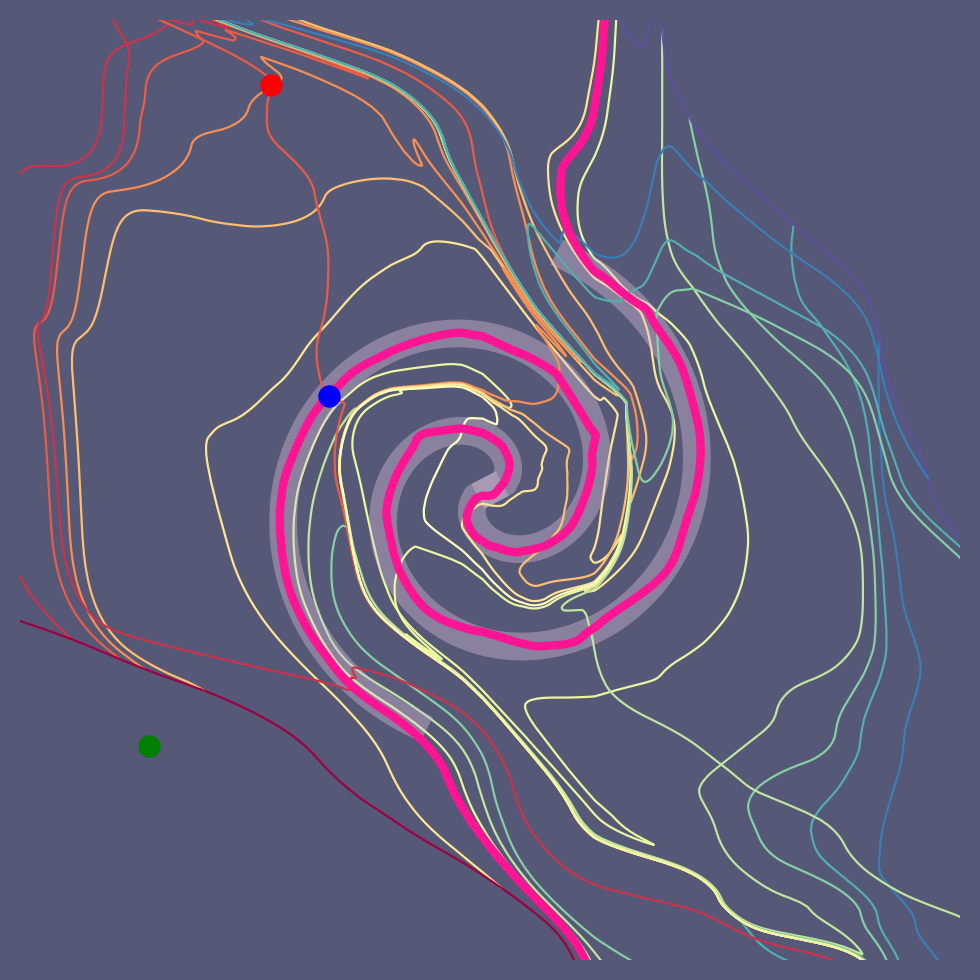

In [11]:
# Generate colours for the sample points
n_samples = 10_000

# Generate samples and project them to the manifold
val_range = 2.5

fig = plt.figure(figsize=(5, 5), dpi=200)

# Set background colour
fig.patch.set_facecolor("#555876")

# Plot the two spirals of the dataset
X, _ = spiral_dataset(n_samples=500, noise=0, n_rotations=1.2)
plt.plot(*X[:249].T, c="thistle", lw=10, alpha=0.4)
plt.plot(*X[250:].T, c="thistle", lw=10, alpha=0.4)

# Plot grid lines
grid_density = 13
warped       = True

for y_val in torch.linspace(-1, 1, grid_density) * val_range:
    if y_val.abs() < 0.1:
        color  = "deeppink"
        lw     = 3
        zorder = 3
    else:
        color = plt.get_cmap("Spectral")((y_val / val_range + 1) / 2)
        lw    = 0.8
        zorder = 1
    
    xs          = torch.linspace(-val_range, val_range, n_samples)
    ys          = torch.full_like(xs, y_val.item())
    line_points = torch.column_stack([xs, ys])

    # Transform points from latent space to ambiet space
    points_proj = mflow.outer_transform.inverse(line_points)[0].detach().numpy()

    # Plotting
    if warped:
        plt.plot(*points_proj.T, lw=lw, color=color, zorder=zorder)
    else:
        plt.plot(*line_points.T, lw=lw, color=color, zorder=zorder)

for x_val in torch.linspace(-val_range, val_range, grid_density):
    ys          = torch.linspace(-val_range, val_range, n_samples)
    xs          = torch.full_like(xs, x_val.item())
    line_points = torch.column_stack([xs, ys])

    # Transform points from latent space to ambiet space
    points_proj = mflow.outer_transform.inverse(line_points)[0].detach().numpy()

    # Plotting
    color = plt.get_cmap("Spectral")((x_val / val_range + 1) / 2)

    if warped:
        plt.plot(*points_proj.T, lw=0.8, color=color)
    else:
        plt.plot(*line_points.T, lw=0.8, color=color)


# Demonstrate how a point x gets projected onto the manifold
# Pick point x in data space
x = torch.tensor([[-1.07, 1.98]])

# Transform point x into latent space
x_latent_2d = mflow.outer_transform(x)[0].detach().numpy()

# Project sample onto manifold
x_latent = mflow.encode(x)
x_proj   = mflow.decode(x_latent).detach().numpy()

plt.scatter(*x.T,           s=50, zorder=4, c="red")
plt.scatter(*x_latent_2d.T, s=50, zorder=4, c="green")
plt.scatter(*x_proj.T,      s=50, zorder=4, c="blue")

plt.gca().set_aspect("equal", adjustable="box")
plt.axis("off")
plt.xlim(-2.3, 2.3)
plt.ylim(-2.3, 2.3)
plt.tight_layout()
# plt.savefig("../figures/report/grid_mflow_latent.pdf")

In [ ]:
def plot_grid_lines(
        mflow:     torch.nn.Module,
        n_samples: int,
        range:     float,
        axis:      str = "both",
        file_path: Path|None = None
    ):
    # Set up the plot
    plt.figure(figsize=(5, 5), dpi=200)
    plt.scatter(*manifold_points.T, s=1, alpha=1, c="plum")

    grid_values = np.linspace(-range, range, 33)
    
    for val in grid_values:
        # Generate points on a line grid
        if axis in ["x", "both"]:
            line_points = np.column_stack([np.full(n_samples, val), np.linspace(-range, range, n_samples)])
        if axis in ["y", "both"]:
            line_points = np.column_stack([np.linspace(-x_range, x_range, n_samples), np.full(n_samples, val)])
        
        # Convert to torch tensor and ensure float32 dtype
        line_points_tensor = torch.tensor(line_points, dtype=torch.float32)

        # Map grid points from latent space to ambient data space
        points_proj = mflow.outer_transform.inverse(line_points_tensor)[0].detach().numpy()
        
        # Plot the warped grid
        color = "hotpink" if abs(val) < 0.1 else "lightgray"
        lw    = 2         if abs(val) < 0.1 else 0.8
        plt.plot(points_proj[:, 0], points_proj[:, 1], lw=lw, color=color)

    # Finalize plot settings
    plt.gca().set_aspect("equal", adjustable="box")
    plt.axis("off")
    plt.xlim(-2.3, 2.3)
    plt.ylim(-2.3, 2.3)
    plt.tight_layout()

    if file_path is not None:
        plt.savefig(str(file_path))
    
    plt.close()
    plt.cla()
    plt.clf()

# Plot grid lines
range     = 5
n_samples = 10_000
file_path = Path(f"../figures/test.pdf")
plot_grid_lines(mflow, n_samples, range, axis="x", file_path=file_path)

<Figure size 640x480 with 0 Axes>